# Getting Started
- Installing Dependencies
- Downloding Fashion MNIST
- Feature Normalization
- Dataloader

### Import dependencies

In [0]:
import os
import random
import pickle
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

from google_drive_downloader import GoogleDriveDownloader

### Create project directory

In [0]:
!mkdir fashion-mnist

### Configs (paths)

In [0]:
ROOT_DIR = '/fashion-mnist/'
DATA_DIR = ROOT_DIR + 'data/'
DATALOADERS_PKL = DATA_DIR + 'dataloaders.pkl'
TRAIN_FILE = DATA_DIR + 'train.csv' 
TEST_FILE = DATA_DIR + 'test.csv' 
MODEL_SAVE_DIR = ROOT_DIR + 'models/'
MNIST_TRAIN_FILE_ID = '1z8vHjGLPIaFU4VY-QfYa8pajIrWSZj87'
MNIST_TEST_FILE_ID = '1u7RDFVb-B2R5zy-rdVuJHRZAI2ZuzesN'

### Download the dataset

In [4]:
GoogleDriveDownloader.download_file_from_google_drive(file_id=MNIST_TRAIN_FILE_ID, dest_path=TRAIN_FILE, unzip=False)
GoogleDriveDownloader.download_file_from_google_drive(file_id=MNIST_TEST_FILE_ID, dest_path=TEST_FILE, unzip=False)

In [5]:
 !ls /fashion-mnist/data

test.csv  train.csv


### Loading the data into dataframe

In [0]:
data_train = pd.read_csv(TRAIN_FILE)
data_test = pd.read_csv(TEST_FILE)

In [7]:
print('Number of training data: {}'.format(len(data_train)))
print('Number of testing data: {}'.format(len(data_test)))

Number of training data: 60000
Number of testing data: 10000


### Visualize the dataframe

In [8]:
print(data_train.iloc[:, 0:9].head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8
0      2       0       0       0       0       0       0       0       0
1      9       0       0       0       0       0       0       0       0
2      6       0       0       0       0       0       0       0       5
3      0       0       0       0       1       2       0       0       0
4      3       0       0       0       0       0       0       0       0


### Prepare the dataset
- Extract pixel values from the dataframe (dimension $1\times 784$) and store them into array
- Extract corresponding labels and store them into array
- Reshape image from $1\times 784$ to $28\times 28$

In [0]:
# before reshaping, X has shape 60000x784
X = np.array(data_train.iloc[:, 1:]).reshape(60000, 28, 28)
y = np.array(data_train.iloc[:, 0])

test_x = np.array(data_test.iloc[:, 1:]).reshape(10000, 28, 28)
test_y = np.array(data_test.iloc[:, 0])

### Normalization: Per image normalization (method 2 from PP)
For each image, normalized the image by removing the mean and dividing by the standard deviation:
$$
    x_{norm}^{(i)} = \frac{x^{(i)} - \bar{x}^{(i)}}{\sigma_{x^{(i)}}}
$$


In [0]:
def normalize(x):
    mean = x.mean()
    std = x.std()
    return (x - mean)/std

In [0]:
X = X.astype('float32')
test_x = test_x.astype('float32')

X = np.array([normalize(x) for x in X])
test_x = np.array([normalize(x) for x in test_x])

### Train/validation split
- training set - 80% => 48,000
- validation set - 20% => 12,000

In [0]:
data_size = len(y) # 60000
train_pct = 0.8

train_size = round(data_size*train_pct)
valid_size = data_size - train_size 

# A list of id (1,...,60000)
examples = range(data_size)

# draw training index
train_ix = random.sample(examples, train_size)

#: remove training data index
valid_ix = [example for example in examples if example not in train_ix]

train_x = X[train_ix]
train_y = y[train_ix]

valid_x = X[valid_ix]
valid_y = y[valid_ix]

In [13]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(test_y.shape)

(48000, 28, 28)
(48000,)
(12000, 28, 28)
(12000,)
(10000, 28, 28)
(10000,)


In [0]:
def data_loader(inputs, targets, batch_size):
    """Provides an iterator over a dataset
    
    Return a list of tupple [(batch_x_1, batch_y_1),...]
    """
    data_size = len(targets)
    examples = range(data_size)

    dataloader = []

    for _ in range(int(data_size/batch_size)):

        #: randomly select examples for current SGD iteration
        mini_batch = random.sample(examples, batch_size)

        #: remove current example from the list of examples
        examples = [example for example in examples if example not in mini_batch]

        #: Convert array to tensor of size [batch_size, 1, img_size, img_size]
        batch_x = Variable(torch.Tensor(inputs[mini_batch, :])).view(batch_size, 1, 28, 28)
        batch_y = Variable(torch.LongTensor(targets[mini_batch]))

        dataloader.append((batch_x, batch_y))

    return dataloader

In [0]:
# In general, batch_size is a hyperparameter, but for purpose of rapidity 
# its harcoded here
trainloader = data_loader(train_x, train_y, 64)

# batch size for dev and test set only to ensure 
# that we are not out of ram when evaluating the model
devloader = data_loader(valid_x, valid_y, 64)
testloader = data_loader(test_x, test_y, 64)



```
# This is formatted as code
```

### Filter visualization model

layer | filter size  | stride | output | # weights
--- | --- | --- | --- | ---
input |                  |            |  1 $\times$ 28 $\times$ 28 | 0
conv | 10 $\times$ 1  $\times$  28 $\times$ 28 | 1 |  10 $\times$ 1 $\times$ 1 | 7840
ReLU||| 10 $\times$ 1 $\times$ 1 | 0
Reshape to vector |||  10 | 0
FC | 10 $\times$ 10|| 10 | 100
trainable parameters: 7940

In [0]:
class CNN(nn.Module):
    
    def __init__(self):
        
        self.num_classes = 10
        
        super(CNN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=28),
            nn.ReLU()
        )
        
    def reshape_to_vector(self, x, dense_input_shape):
        return x.view(-1, dense_input_shape)

    def forward(self, x):
        x = self.conv(x)
        x = self.reshape_to_vector(x, 10)
        return F.log_softmax(x, dim=1)

In [0]:
class Classifier(CNN):
    
    def __init__(self, num_epoch, learning_rate=0.01, momentum=0.):
        
        self.num_epochs = num_epoch
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        super(Classifier, self).__init__()
    
    def evaluate(self, dataloader):
        total, correct = 0., 0.

        for (inputs, targets) in dataloader:
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

        return 100.*correct/total
    
    def train(self, trainloader, devloader):
        
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=self.momentum)
        
        for epoch in range(self.num_epochs):
            
            start_time = time.time()

            for (inputs, targets) in trainloader:
                
                optimizer.zero_grad()
                
                outputs = self.forward(inputs)
                
                loss = nn.NLLLoss()(outputs, targets)
                
                loss.backward() 
                
                optimizer.step()    
            
            train_acc = self.evaluate(trainloader)
            valid_acc = self.evaluate(devloader)

            print('Epoch: {:.0f}\tTrain acc: {:.2f}\tDev acc: {:.2f}'.format(epoch+1, train_acc, valid_acc))
            print("--- %s seconds ---" % (time.time() - start_time))

In [18]:
clf = Classifier(num_epoch=5)
clf.train(trainloader, devloader)

Epoch: 1	Train acc: 76.58	Dev acc: 76.73
--- 1.8353447914123535 seconds ---
Epoch: 2	Train acc: 77.69	Dev acc: 77.76
--- 1.6005504131317139 seconds ---
Epoch: 3	Train acc: 78.27	Dev acc: 78.12
--- 1.6170949935913086 seconds ---
Epoch: 4	Train acc: 78.60	Dev acc: 78.40
--- 1.5955994129180908 seconds ---
Epoch: 5	Train acc: 78.84	Dev acc: 78.58
--- 1.5977237224578857 seconds ---


In [0]:
def rescale_pixels(x):
    return (255*(x - np.min(x))/np.ptp(x)).astype(int)

In [0]:
for name, param in clf.named_parameters():
    if name == 'conv.0.weight':
        conv_weight = [w[0].data.numpy() for w in param]

In [0]:
def print_filter(interpolation):
    fig = plt.figure()

    for i in range(10):
        cur_filter = conv_weight[i]
        cur_filter = rescale_pixels(cur_filter)

        ax = fig.add_subplot(4, 5, i+1)
        ax.grid(False)         
        ax.set_xticklabels([])
        ax.set_yticklabels([]) 

        ax.imshow(cur_filter, interpolation=interpolation)

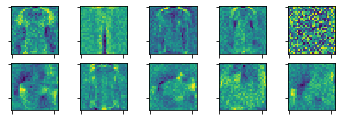

In [22]:
print_filter('nearest')

### Define the text labels

In [0]:
fashion_mnist_labels = { 
    0: "T-shirt/top",                           
    1: "Trouser",      
    2: "Pullover",      
    3: "Dress",         
    4: "Coat",         
    5: "Sandal",       
    6: "Shirt",         
    7: "Sneaker",      
    8: "Bag",          
    9: "Ankle boot",   
}

In [0]:
class CNN(nn.Module):
    
    def __init__(self):
        
        self.num_classes = 10
        
        super(CNN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
        )
        
        self.dense = nn.Sequential(
            nn.Linear(25600, self.num_classes)
        )
        
    def reshape_to_vector(self, x, dense_input_shape):
        return x.view(-1, dense_input_shape)

    def forward(self, x):
        x = self.conv(x)
        x = self.reshape_to_vector(x, 25600)
        x = self.dense(x)
        x = F.log_softmax(x, dim=1)
        return x

class Classifier(CNN):
    
    def __init__(self, num_epoch, learning_rate=0.01, momentum=0.5):
        
        self.num_epochs = num_epoch
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.losses = []
        self.train_accs = []
        self.valid_accs = []
        
        super(Classifier, self).__init__()
    
    def predict(self, x):
        output = self.forward(x).data.numpy()
        return np.argmax(output)
    
    def evaluate(self, dataloader):
        total, correct = 0., 0.

        for (inputs, targets) in dataloader:
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum().item()

        return 100.*correct/total
    
    def train(self, trainloader, devloader):
        num_batch = len(trainloader)
        
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate, momentum=self.momentum)
        
        for epoch in range(self.num_epochs):
            
            start_time = time.time()
            
            epoch_loss = 0
            
            for i in tqdm(range(num_batch)):
                
                (inputs, targets) = trainloader[i]
                
                optimizer.zero_grad()
                
                outputs = self.forward(inputs)
                
                loss = nn.NLLLoss()(outputs, targets) # compute loss
                
                loss.backward() # compute derivative
                
                optimizer.step() # apply update   
                
                epoch_loss += loss.item()/num_batch
                
            self.losses.append(epoch_loss)
            
            train_acc = self.evaluate(trainloader)
            valid_acc = self.evaluate(devloader)
            
            self.train_accs.append(train_acc)
            self.valid_accs.append(valid_acc)

            print('Epoch: {:.0f}\tLoss: {:.3f}\tTrain acc: {:.2f}\tDev acc: {:.2f}'.format(epoch+1, epoch_loss, train_acc, valid_acc))
            print("--- %s seconds ---" % (time.time() - start_time))

In [26]:
clf = Classifier(num_epoch=1)
clf.train(trainloader, devloader)

Epoch: 1	Loss: 0.459	Train acc: 92.36	Dev acc: 90.97
--- 1469.968688249588 seconds ---


## Visualization

In [0]:
train_err = 100 - np.array(clf.train_accs)
valid_err = 100 - np.array(clf.valid_accs)

fig_acc = plt.figure(figsize=(10, 4))
plt.plot(train_err)
plt.plot(valid_err)
plt.title('Error rate')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

fig_loss = plt.figure(figsize=(10, 4))
plt.plot(clf.losses)
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Display well classified image

In [0]:
fig = plt.figure()
good_clf = 0
for (inputs, targets) in trainloader:
    for i in range(64):
        x = inputs[i].view(1,1,28,28)
        y = targets[i].item()
        yhat = clf.predict(x)
        if yhat == y:
            x = x.numpy().reshape(28, 28)
            x = (255*(x - np.min(x))/np.ptp(x)).astype(int)

            ax = fig.add_subplot(2, 5, good_clf+1)
            ax.set_title('target: {}\npred: {}'.format(fashion_mnist_labels[y], fashion_mnist_labels[yhat]))
            ax.grid(False)         # remove grid 
            ax.set_xticklabels([]) # remove x label
            ax.set_yticklabels([]) # remove y label
            ax.imshow(x, interpolation='nearest')

            good_clf += 1

        if good_clf > 9: break

    if good_clf > 9: break

### Display miss classified images

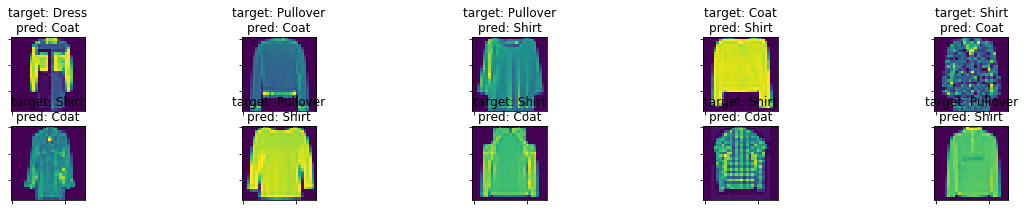

In [27]:
plt.rcParams["figure.figsize"] = (20,3)

fig = plt.figure()
bad_clf = 0
for (inputs, targets) in trainloader:
    for i in range(64):
        x = inputs[i].view(1,1,28,28)
        y = targets[i].item()
        yhat = clf.predict(x)
        if yhat != y:
            x = x.numpy().reshape(28, 28)
            x = (255*(x - np.min(x))/np.ptp(x)).astype(int)
            ax = fig.add_subplot(2, 5, bad_clf+1)
            ax.set_title('target: {}\npred: {}'.format(fashion_mnist_labels[y], fashion_mnist_labels[yhat]))
            ax.grid(False)         # remove grid 
            ax.set_xticklabels([]) # remove x label
            ax.set_yticklabels([]) # remove y label
            ax.imshow(x, interpolation='nearest')
            bad_clf += 1
        if bad_clf > 9: break
    if bad_clf > 9: break